# Preprocessed Alzheimer's Patient Brain Scan Data
Building 10 models to detect severity of Alzheimer's.

# Set-up

## Importing Libraries

In [ ]:
from google.colab import drive
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from PIL import Image
import imgaug.augmenters as iaa

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.utils import to_categorical


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Mounting Drive, Unzipping Dataset Locally

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/207_Project/preprocess.zip" "./"

In [ ]:
!unzip preprocess.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/N

## Loading in Dataset
Creating a dictionary `images`, that maps Alzheimer's severity class to a list of images in that class

In [ ]:
# Base directory where the Dataset folder is located
base_dir = './Dataset'

# Subfolders within the Dataset folder
categories = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Dictionary to hold images, with categories as keys
images = {category: [] for category in categories}

# Loop through each category
for category in categories:
    category_path = os.path.join(base_dir, category)

    # Loop through each image in the category's folder
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):  # Check for jpg files
            image_path = os.path.join(category_path, filename)
            image = Image.open(image_path)
            images[category].append(image)

# Exploratory Data Analysis

## Plotting a single brain from each class

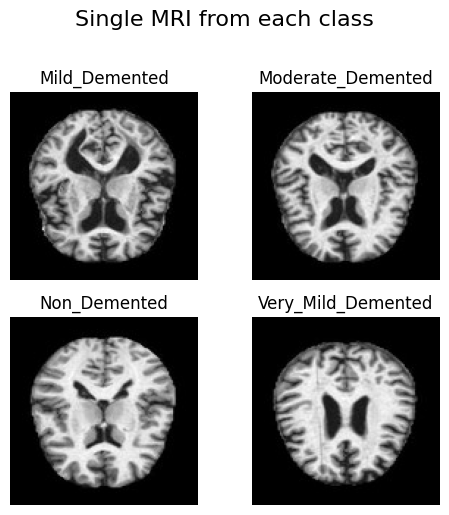

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
fig.suptitle('Single MRI from each class', fontsize=16, y=1.02)
for ax, category in zip(axs.flatten(), categories):
    ax.imshow(images[category][0], cmap='gray')
    ax.axis('off')
    ax.set_title(category)
    # ax.set_title(f"{title}\n{benefit}")
plt.tight_layout()
#plt.savefig('/content/drive/My Drive/207_Project/augmented_images.png', dpi=300)
plt.show()


In [ ]:
print('Observations in Mild_Demented class: ', len(images['Mild_Demented']))
print('Observations in Moderate_Demented class: ', len(images['Moderate_Demented']))
print('Observations in Non_Demented class: ', len(images['Non_Demented']))
print('Observations in Very_Mild_Demented class: ', len(images['Very_Mild_Demented']))

Observations in Mild_Demented class:  896
Observations in Moderate_Demented class:  64
Observations in Non_Demented class:  3200
Observations in Very_Mild_Demented class:  2240


## Creating 5 Non-Deterministic Image Augmentations, and visualizing on 1 particular brain

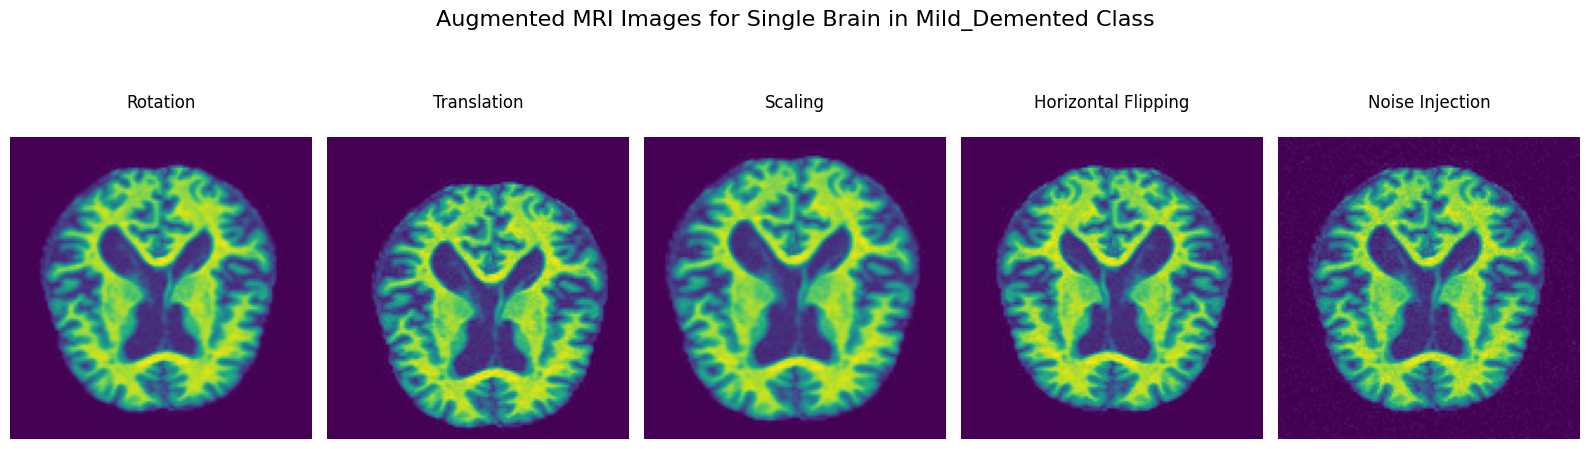

In [ ]:
image = np.array(images['Mild_Demented'][0])
# Define the augmentations
augmenters = [
    ('Rotation', iaa.Affine(rotate=(-10, 10)), "Helps model to be invariant to slight rotations."),
    ('Translation', iaa.Affine(translate_px={"x": (-10, 10), "y": (-10, 10)}), "Helps model to handle slight translations."),
    ('Scaling', iaa.Affine(scale=(0.9, 1.1)), "Helps model to generalize to different brain sizes."),
    ('Horizontal Flipping', iaa.Fliplr(1.0), "Can make the model more robust if condition isn't hemisphere-specific."),
    ('Noise Injection', iaa.AdditiveGaussianNoise(scale=0.02*255), "Simulates MRI scanner noise."),
    # ('Rotation', iaa.Affine(rotate=(-10, 10)), "Helps model to be invariant to slight rotations."),
    # ('Translation', iaa.Affine(translate_px={"x": (-10, 10), "y": (-10, 10)}), "Helps model to handle slight translations."),
    # ('Scaling', iaa.Affine(scale=(0.9, 1.1)), "Helps model to generalize to different brain sizes."),
    # ('Horizontal Flipping', iaa.Fliplr(1.0), "Can make the model more robust if condition isn't hemisphere-specific."),
    # ('Noise Injection', iaa.AdditiveGaussianNoise(scale=0.02*255), "Simulates MRI scanner noise."),
    # ('Rotation', iaa.Affine(rotate=(-10, 10)), "Helps model to be invariant to slight rotations."),
    # ('Translation', iaa.Affine(translate_px={"x": (-10, 10), "y": (-10, 10)}), "Helps model to handle slight translations."),
    # ('Scaling', iaa.Affine(scale=(0.9, 1.1)), "Helps model to generalize to different brain sizes."),
    # ('Horizontal Flipping', iaa.Fliplr(1.0), "Can make the model more robust if condition isn't hemisphere-specific."),
    # ('Noise Injection', iaa.AdditiveGaussianNoise(scale=0.02*255), "Simulates MRI scanner noise."),
    # ('Rotation', iaa.Affine(rotate=(-10, 10)), "Helps model to be invariant to slight rotations."),
    # ('Translation', iaa.Affine(translate_px={"x": (-10, 10), "y": (-10, 10)}), "Helps model to handle slight translations."),
    # ('Scaling', iaa.Affine(scale=(0.9, 1.1)), "Helps model to generalize to different brain sizes."),
    # ('Horizontal Flipping', iaa.Fliplr(1.0), "Can make the model more robust if condition isn't hemisphere-specific."),
    # ('Noise Injection', iaa.AdditiveGaussianNoise(scale=0.02*255), "Simulates MRI scanner noise.")
]

# Apply each augmentation and plot
fig, axs = plt.subplots(1, 5, figsize=(16, 5))
fig.suptitle('Augmented MRI Images for Single Brain in Mild_Demented Class', fontsize=16, y=1.02)
for ax, (title, augmenter, benefit) in zip(axs.flatten(), augmenters):
    # Apply the augmentation
    augmented_image = augmenter.augment_image(image)
    # Plot the augmented image
    ax.imshow(augmented_image) #, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{title}\n")
    # ax.set_title(f"{title}\n{benefit}")
plt.tight_layout()
#plt.savefig('/content/drive/My Drive/207_Project/augmented_images.png', dpi=300)
plt.show()



# Data Preprocessing
Balancing classes in training set through augmentation.

In [ ]:
augmenters = [
    ('Rotation', iaa.Affine(rotate=(-10, 10)), "Helps model to be invariant to slight rotations."),
    ('Translation', iaa.Affine(translate_px={"x": (-10, 10), "y": (-10, 10)}), "Helps model to handle slight translations."),
    ('Scaling', iaa.Affine(scale=(0.9, 1.1)), "Helps model to generalize to different brain sizes."),
    ('Horizontal Flipping', iaa.Fliplr(1.0), "Can make the model more robust if condition isn't hemisphere-specific."),
    ('Noise Injection', iaa.AdditiveGaussianNoise(scale=0.02*255), "Simulates MRI scanner noise.")
]

## Initializing X and y arrays of images and labels respectively

In [ ]:
# Initialize empty lists for the images (X) and the labels (y)
X = []
y = []

# Create a mapping of the classes to integers
class_mapping = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}

# Populate the lists with the image data and the corresponding labels
for class_label, image_list in images.items():
    X.extend(image_list)  # Add the images
    y.extend([class_mapping[class_label]] * len(image_list))  # Add the class label indices

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
print('Shape of X: ', X.shape, '\nShape of y: ', y.shape)

Shape of X:  (6400, 128, 128) 
Shape of y:  (6400,)


## Splitting data into training, validation, and test sets

In [ ]:
def split_data(X, y, split):
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    # FILL IN CODE HERE #
    indices = np.arange(X.shape[0])
    shuffled_indices = np.random.permutation(indices)
    images = X[shuffled_indices]
    labels = y[shuffled_indices]

    # create data splits
    # FILL IN CODE HERE #
    N = images.shape[0]
    split_1 = int(split[0]*N)
    split_2 = int((split[0] + split[1])*N)

    X_train = images[:split_1]
    y_train = labels[:split_1]

    X_val = images[split_1:split_2]
    y_val = labels[split_1:split_2]

    X_test = images[split_2:]
    y_test = labels[split_2:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, [0.6, 0.2, 0.2])

In [ ]:
# Print shapes
print('Shape of train images: ', X_train.shape)
print('Shape of train labels: ', y_train.shape)

print('\nShape of val images: ', X_val.shape)
print('Shape of train labels: ', y_val.shape)

print('\nShape of test images: ', X_test.shape)
print('Shape of test labels: ', y_test.shape)

Shape of train images:  (3840, 128, 128)
Shape of train labels:  (3840,)

Shape of val images:  (1280, 128, 128)
Shape of train labels:  (1280,)

Shape of test images:  (1280, 128, 128)
Shape of test labels:  (1280,)


## Class Distributions

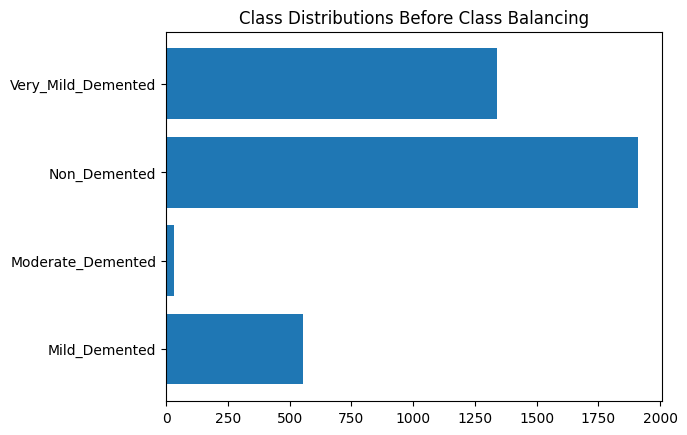

In [ ]:
class_counts = pd.Series(y_train).value_counts()
plt.barh(class_counts.index, class_counts.values, tick_label = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'])
plt.title('Class Distributions Before Class Balancing')
plt.show()

## Class Balancing Algorithm
Augmenting the training data only

In [ ]:
# Split x train based on the classes
X_train_sorted = X_train[np.argsort(y_train)]
sizes = [555, 33, 1912, 1340]

X_train_splits = np.split(X_train_sorted, np.cumsum(sizes)[:-1])
class0_train, class1_train, class2_train, class3_train = X_train_splits

In [ ]:
X_train.shape, y_train.shape

((3840, 128, 128), (3840,))

In [ ]:
def rand_augment(augmenters, x):
  # Helper function to choose a random augmenter out of the 5 possible augmenters to apply to image x
  idx = np.random.randint(len(augmenters))
  augmenter = augmenters[idx][1]
  return augmenter.augment_image(x)

In [ ]:
# Augment each class until it reaches the target size of 1912
augmented_images_0 = class0_train.copy()  # Start with a copy of class0_train
augmented_images_1 = class1_train.copy()  # Start with a copy of class1_train
augmented_images_3 = class3_train.copy()  # Start with a copy of class3_train
target_size = 1912  # Target size

while len(augmented_images_0) < target_size:
    # Select a random image from augmented_images_0
    random_index = np.random.randint(0, len(augmented_images_0))
    random_image = augmented_images_0[random_index]
    # Augment the image
    augmented_image = rand_augment(augmenters, random_image)
    # Append the augmented image - Note: np.append is not very efficient in a loop for this use case
    augmented_images_0 = np.concatenate((augmented_images_0, [augmented_image]), axis=0)

while len(augmented_images_1) < target_size:
    random_index = np.random.randint(0, len(augmented_images_1))
    random_image = augmented_images_1[random_index]
    augmented_image = rand_augment(augmenters, random_image)
    augmented_images_1 = np.concatenate((augmented_images_1, [augmented_image]), axis=0)

while len(augmented_images_3) < target_size:
    random_index = np.random.randint(0, len(augmented_images_3))
    random_image = augmented_images_3[random_index]
    augmented_image = rand_augment(augmenters, random_image)
    augmented_images_3 = np.concatenate((augmented_images_3, [augmented_image]), axis=0)

augmented_images_0.shape, augmented_images_1.shape, augmented_images_3.shape

((1912, 128, 128), (1912, 128, 128), (1912, 128, 128))

In [ ]:
# Concatenating all of our augmented training observations
X_train_augment = np.concatenate((augmented_images_0, augmented_images_1, class2_train, augmented_images_3))

In [ ]:
# Concatenating all of our training labels to match up with the newly augmented and concatenated training observations
labels_0 = np.full(len(augmented_images_0), 0)
labels_1 = np.full(len(augmented_images_1), 1)
labels_2 = np.full(len(class2_train), 2)
labels_3 = np.full(len(augmented_images_3), 3)
y_train = np.concatenate((labels_0, labels_1, labels_2, labels_3), axis = 0)

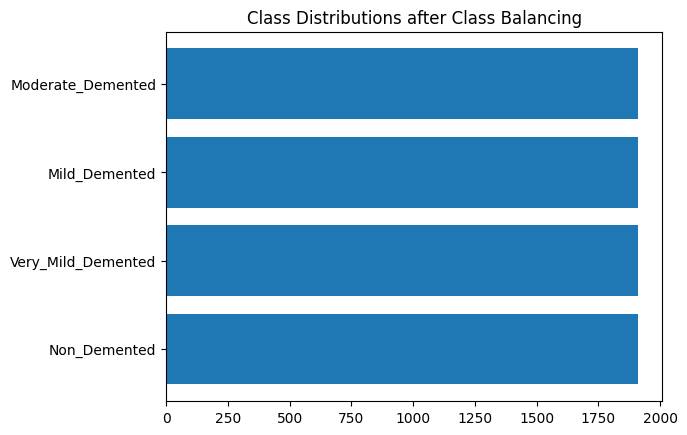

In [ ]:
class_counts = pd.Series(y_train).value_counts()
plt.barh(class_counts.index, class_counts.values, tick_label = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'])
plt.title('Class Distributions after Class Balancing')
plt.show()

# Modeling

## Simple Baseline Logistic Regression Model

In [ ]:
n_classes = 4
learning_rate = 0.01

def build_custom_lr(n_classes, learning_rate):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                metrics=['accuracy'])
  return model

lr_model = build_custom_lr(n_classes, learning_rate)

In [ ]:
lr_history = lr_model.fit(X_train_augment, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
239/239 [==============================] - 2s 5ms/step - loss: 371321.9375 - accuracy: 0.3461 - val_loss: 123277.8594 - val_accuracy: 0.4508
Epoch 2/3
239/239 [==============================] - 1s 5ms/step - loss: 248918.6562 - accuracy: 0.4304 - val_loss: 302064.5625 - val_accuracy: 0.3672
Epoch 3/3
239/239 [==============================] - 1s 5ms/step - loss: 228086.5000 - accuracy: 0.4566 - val_loss: 317420.6250 - val_accuracy: 0.4906


In [ ]:
lr_test_loss, lr_test_acc = lr_model.evaluate(X_test, y_test)
print(f"Test accuracy: {lr_test_acc}, Test loss: {lr_test_loss}")

40/40 [==============================] - 0s 2ms/step - loss: 298864.5312 - accuracy: 0.5063
Test accuracy: 0.5062500238418579, Test loss: 298864.53125


In [ ]:
lr_predictions = lr_model.predict(X_test)
lr_predicted_classes = np.argmax(lr_predictions, axis=1)

40/40 [==============================] - 0s 2ms/step


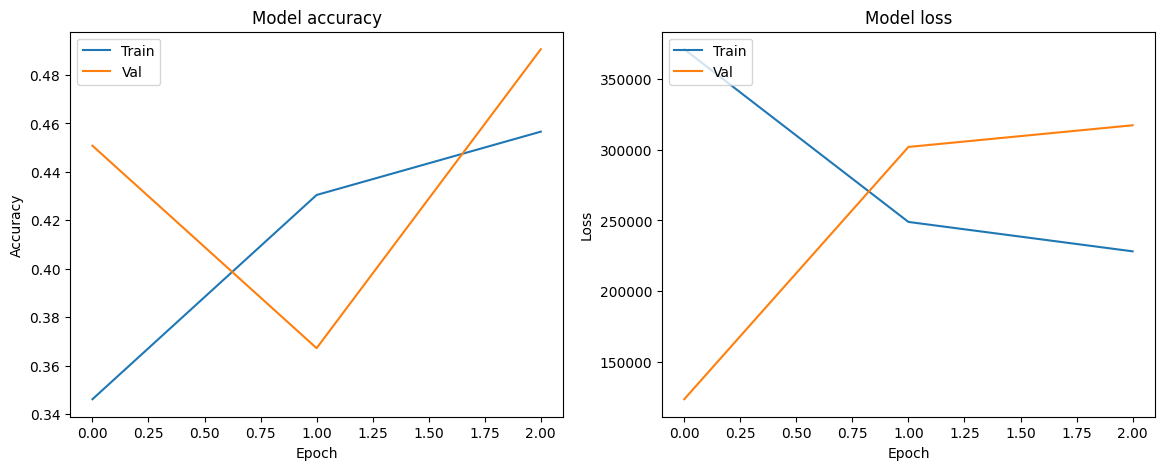

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(lr_history.history['accuracy'])
plt.plot(lr_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lr_history.history['loss'])
plt.plot(lr_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

## Advanced Logistic Regression Model

In [ ]:
n_classes = 4
learning_rate = 0.0001

def build_advanced_lr(n_classes, learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax'
    ))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True)

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

lr_model_adv = build_advanced_lr(n_classes, learning_rate)

In [ ]:
lr_history_adv = lr_model_adv.fit(X_train_augment, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
239/239 [==============================] - 2s 8ms/step - loss: 983.1467 - accuracy: 0.7359 - val_loss: 1688.7004 - val_accuracy: 0.6609
Epoch 2/20
239/239 [==============================] - 2s 6ms/step - loss: 993.0835 - accuracy: 0.7378 - val_loss: 1051.9160 - val_accuracy: 0.7211
Epoch 3/20
239/239 [==============================] - 1s 6ms/step - loss: 751.7086 - accuracy: 0.7857 - val_loss: 543.0329 - val_accuracy: 0.7922
Epoch 4/20
239/239 [==============================] - 2s 7ms/step - loss: 777.3513 - accuracy: 0.7755 - val_loss: 532.2557 - val_accuracy: 0.8031
Epoch 5/20
239/239 [==============================] - 2s 9ms/step - loss: 932.6705 - accuracy: 0.7631 - val_loss: 753.2904 - val_accuracy: 0.7727
Epoch 6/20
239/239 [==============================] - 2s 9ms/step - loss: 634.9102 - accuracy: 0.7999 - val_loss: 1927.8033 - val_accuracy: 0.6734
Epoch 7/20
239/239 [==============================] - 2s 8ms/step - loss: 655.2162 - accuracy: 0.7964 - val_loss: 713.659

In [ ]:
lr_adv_test_loss, lr_adv_test_acc = lr_model_adv.evaluate(X_test, y_test)
print(f"Test accuracy: {lr_adv_test_acc}, Test loss: {lr_adv_test_loss}")

40/40 [==============================] - 0s 2ms/step - loss: 326.9008 - accuracy: 0.8609
Test accuracy: 0.8609374761581421, Test loss: 326.90081787109375


In [ ]:
lr_adv_predictions = lr_model_adv.predict(X_test)
lr_adv_predicted_classes = np.argmax(lr_adv_predictions, axis=1)

40/40 [==============================] - 0s 2ms/step


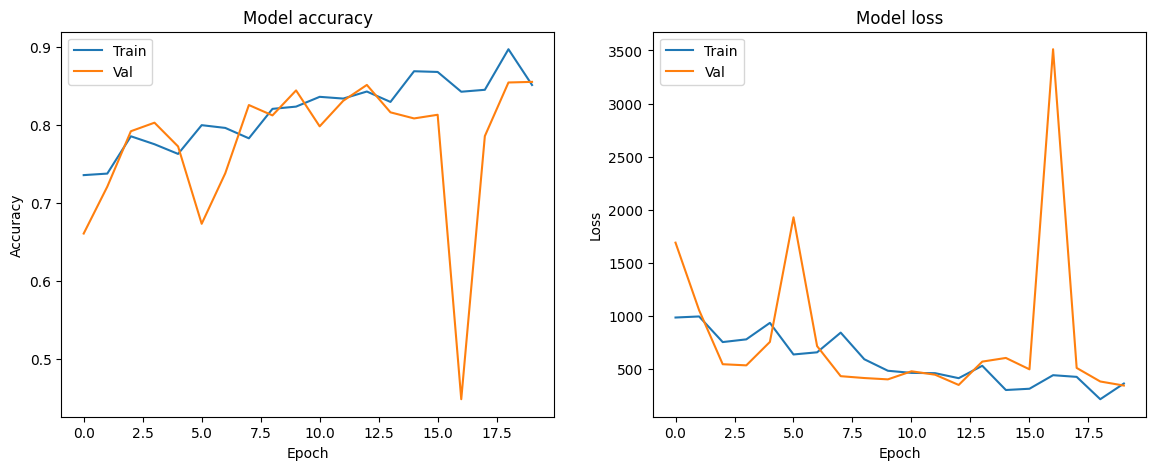

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(lr_history_adv.history['accuracy'])
plt.plot(lr_history_adv.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lr_history_adv.history['loss'])
plt.plot(lr_history_adv.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

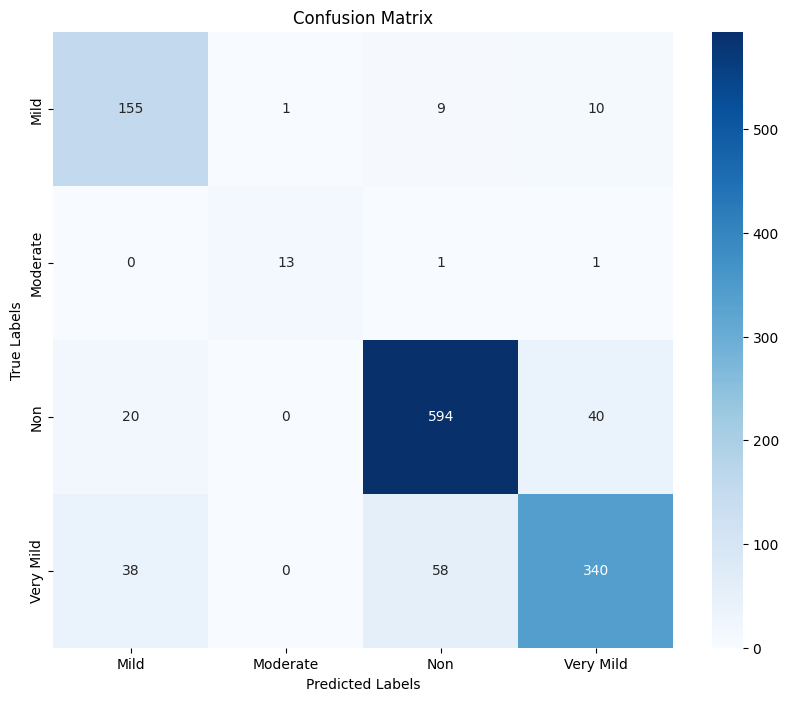

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

conf_matrix = confusion_matrix(y_test, lr_adv_predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Mild", "Moderate", "Non", "Very Mild"], yticklabels=["Mild", "Moderate", "Non", "Very Mild"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Simple Baseline Decision Tree Model

In [ ]:
# Decision trees use two dimensional data -- flattening the images

X_train_augment_flat = X_train_augment.reshape(X_train_augment.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
# Fit Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=7)
dt_model.fit(X_train_augment_flat, y_train)

DecisionTreeClassifier(random_state=7)

In [ ]:
# Predictions
y_train_pred = dt_model.predict(X_train_augment_flat)
y_val_pred = dt_model.predict(X_val_flat)

In [ ]:
# Training, Validation & Test Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = dt_model.predict(X_test_flat)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}, Test accuracy: {test_accuracy}")

Train accuracy: 1.0, Validation accuracy: 0.68984375, Test accuracy: 0.66953125


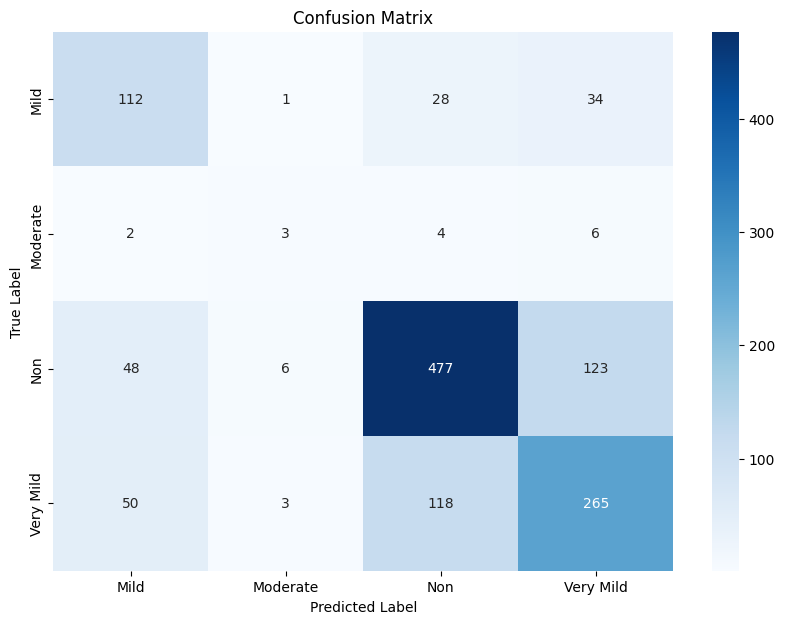

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Mild", "Moderate", "Non", "Very Mild"], yticklabels=["Mild", "Moderate", "Non", "Very Mild"])

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Simple Baseline Random Forest Model

In [ ]:
X_train_augment_flat = X_train_augment.reshape(X_train_augment.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
rf_clf.fit(X_train_augment_flat, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
y_train_pred = rf_clf.predict(X_train_augment_flat)
y_val_pred = rf_clf.predict(X_val_flat)
y_test_pred = rf_clf.predict(X_test_flat)


train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}, Test accuracy: {test_accuracy}")

Train accuracy: 0.9946391213389121, Validation accuracy: 0.78515625, Test accuracy: 0.76328125


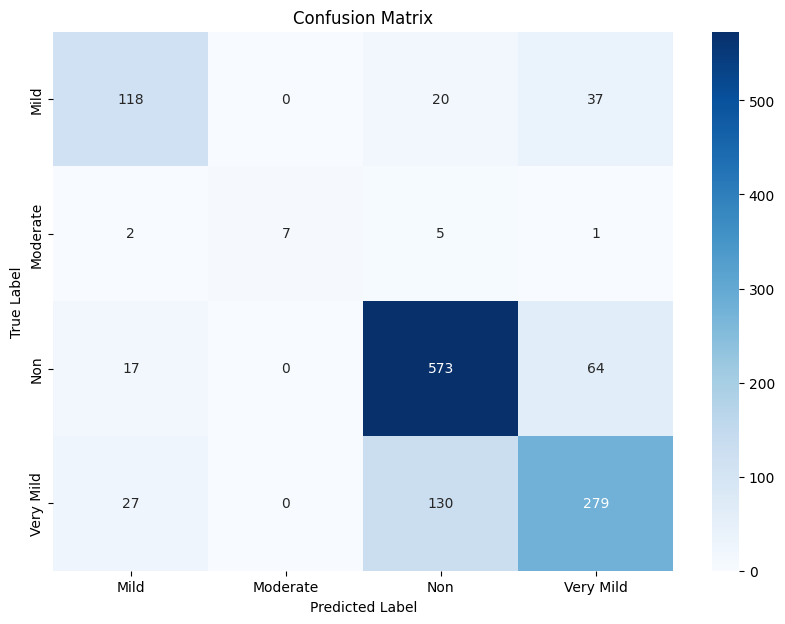

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Mild", "Moderate", "Non", "Very Mild"], yticklabels=["Mild", "Moderate", "Non", "Very Mild"])

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Advanced Random Forest Model

In [ ]:
X_train_augment_flat = X_train_augment.reshape(X_train_augment.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
# Define parameter grid for grid search
param_grid = {
    'n_estimators': [20, 50],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_augment_flat, y_train)

# Get best parameters from grid search
best_params = grid_search.best_params_

# Train Random Forest with best parameters
rf_clf_best = RandomForestClassifier(random_state=42, **best_params)
rf_clf_best.fit(X_train_augment_flat, y_train)

# Predictions
y_train_pred = rf_clf_best.predict(X_train_augment_flat)
y_val_pred = rf_clf_best.predict(X_val_flat)
y_test_pred = rf_clf_best.predict(X_test_flat)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print(f"Best parameters: {best_params}")
print(f"Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}, Test accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Train accuracy: 1.0, Validation accuracy: 0.88359375, Test accuracy: 0.87734375


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy: 1.0, Validation accuracy: 0.86796875, Test accuracy: 0.86328125


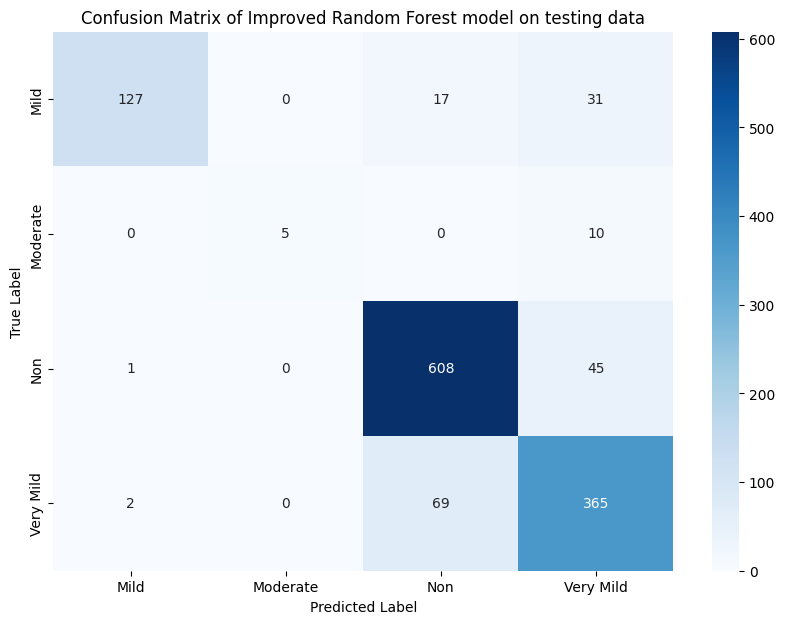

In [ ]:
rf_clf_improved = RandomForestClassifier(max_depth=None,max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=50)

rf_clf_improved.fit(X_train_augment_flat, y_train)

y_train_pred = rf_clf_improved.predict(X_train_augment_flat)
y_val_pred = rf_clf_improved.predict(X_val_flat)
y_test_pred = rf_clf_improved.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}, Test accuracy: {test_accuracy}")

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Mild", "Moderate", "Non", "Very Mild"], yticklabels=["Mild", "Moderate", "Non", "Very Mild"])

plt.title('Confusion Matrix of Improved Random Forest model on testing data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Baseline CNN Model

In [ ]:
input_shape = (128, 128, 1)
num_classes = 4

def build_custom_cnn(input_shape, num_classes):
  model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = build_custom_cnn(input_shape, num_classes)

In [ ]:
history = model.fit(X_train_augment, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
239/239 [==============================] - 7s 22ms/step - loss: 48.8748 - accuracy: 0.5377 - val_loss: 0.9336 - val_accuracy: 0.5508
Epoch 2/3
239/239 [==============================] - 5s 22ms/step - loss: 0.6408 - accuracy: 0.7172 - val_loss: 0.7926 - val_accuracy: 0.6250
Epoch 3/3
239/239 [==============================] - 6s 25ms/step - loss: 0.3884 - accuracy: 0.8360 - val_loss: 0.6294 - val_accuracy: 0.7141


In [ ]:
model_save_path = "/content/drive/My Drive/207_Project/Preprocessed_2D_Models/baseline_CNN.h5"

# Save the model in the TensorFlow SavedModel format
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

40/40 [==============================] - 0s 9ms/step - loss: 0.6287 - accuracy: 0.7203
Test accuracy: 0.7203124761581421, Test loss: 0.6287466883659363


In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

40/40 [==============================] - 0s 5ms/step


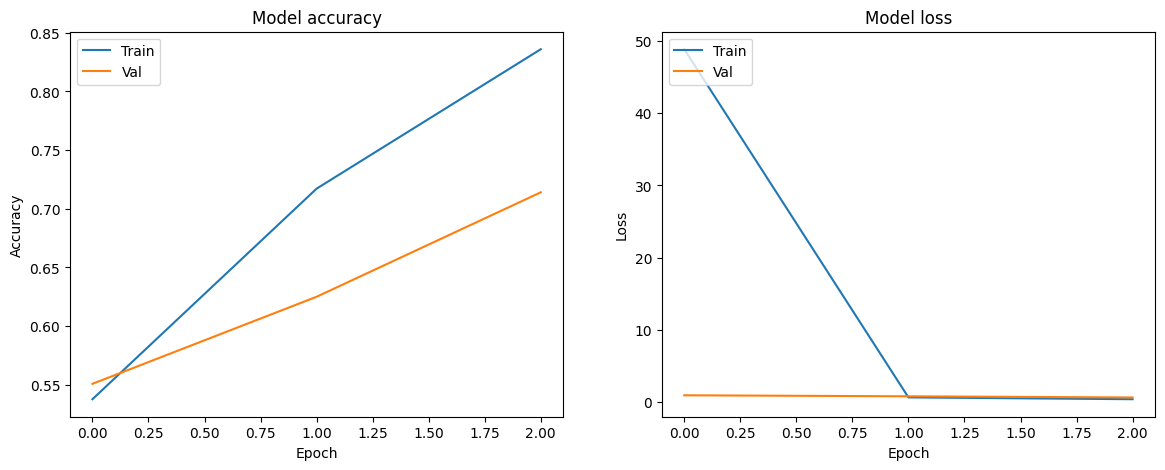

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

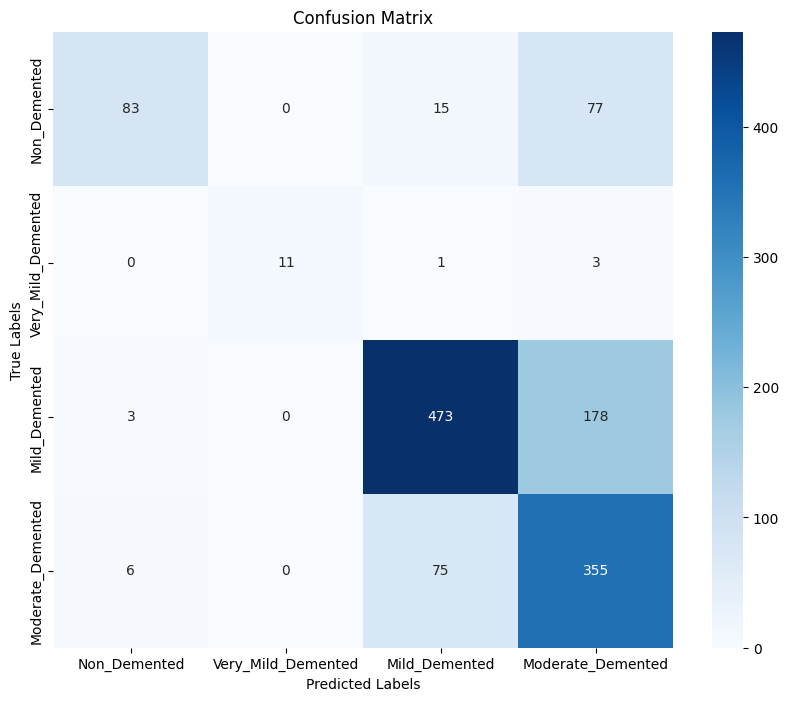

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

conf_matrix = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Advanced CNN Model #1

In [ ]:
from tensorflow.keras import optimizers

input_shape = (128, 128, 1)
num_classes = 4

def build_custom_cnn(input_shape, num_classes):
  model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = build_custom_cnn(input_shape, num_classes)

In [ ]:
history = model.fit(X_train_augment, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
239/239 [==============================] - 215s 890ms/step - loss: 2.8923 - accuracy: 0.4987 - val_loss: 0.9060 - val_accuracy: 0.6062
Epoch 2/3
239/239 [==============================] - 239s 1s/step - loss: 0.6562 - accuracy: 0.7306 - val_loss: 0.7076 - val_accuracy: 0.7070
Epoch 3/3
239/239 [==============================] - 227s 949ms/step - loss: 0.4297 - accuracy: 0.8371 - val_loss: 0.6138 - val_accuracy: 0.7461


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

40/40 [==============================] - 14s 353ms/step - loss: 0.5973 - accuracy: 0.7492
Test accuracy: 0.749218761920929, Test loss: 0.5972740650177002


In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

40/40 [==============================] - 9s 219ms/step


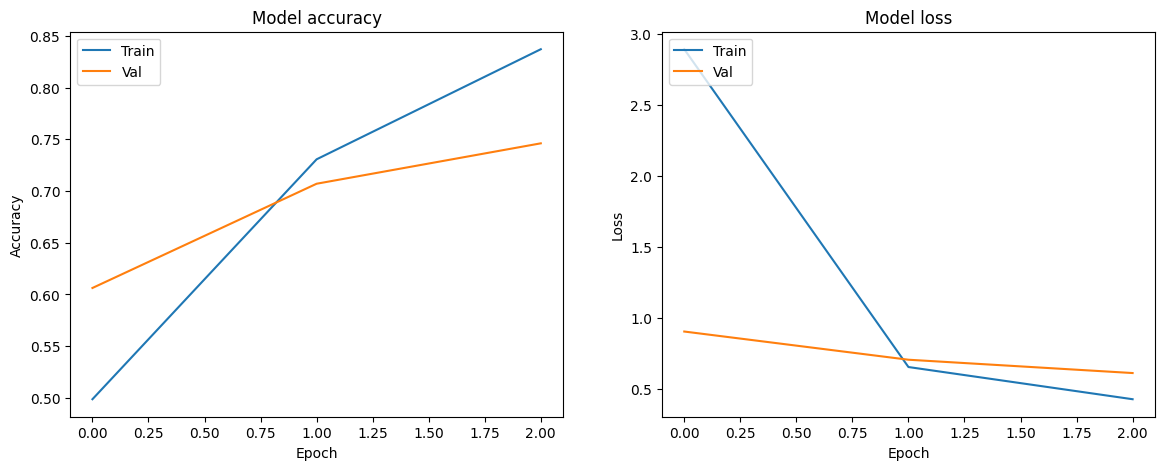

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

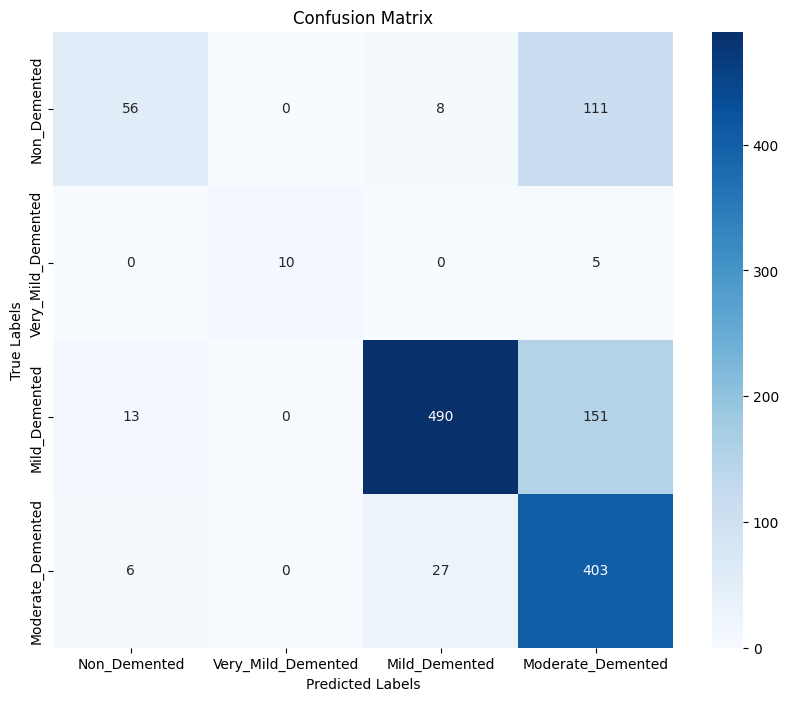

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

conf_matrix = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Advanced CNN Model #2

In [ ]:
input_shape = (128, 128, 1)
num_classes = 4

def build_custom_cnn(input_shape, num_classes):
  model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(4, activation='softmax')
  ])

  model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = build_custom_cnn(input_shape, num_classes)

In [ ]:
history = model.fit(X_train_augment, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
239/239 [==============================] - 8s 23ms/step - loss: 2.3713 - accuracy: 0.5225 - val_loss: 0.8239 - val_accuracy: 0.6523
Epoch 2/5
239/239 [==============================] - 5s 23ms/step - loss: 0.6950 - accuracy: 0.7155 - val_loss: 0.6109 - val_accuracy: 0.7539
Epoch 3/5
239/239 [==============================] - 5s 23ms/step - loss: 0.4323 - accuracy: 0.8326 - val_loss: 0.4021 - val_accuracy: 0.8461
Epoch 4/5
239/239 [==============================] - 6s 23ms/step - loss: 0.2981 - accuracy: 0.8906 - val_loss: 0.2805 - val_accuracy: 0.9125
Epoch 5/5
239/239 [==============================] - 5s 22ms/step - loss: 0.2098 - accuracy: 0.9297 - val_loss: 0.2278 - val_accuracy: 0.9258


In [ ]:
model_save_path = "/content/drive/My Drive/207_Project/Preprocessed_2D_Models/advanced_CNN.h5"

# Save the model in the TensorFlow SavedModel format
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

40/40 [==============================] - 0s 6ms/step - loss: 0.2310 - accuracy: 0.9297
Test accuracy: 0.9296875, Test loss: 0.23102541267871857


In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

40/40 [==============================] - 0s 5ms/step


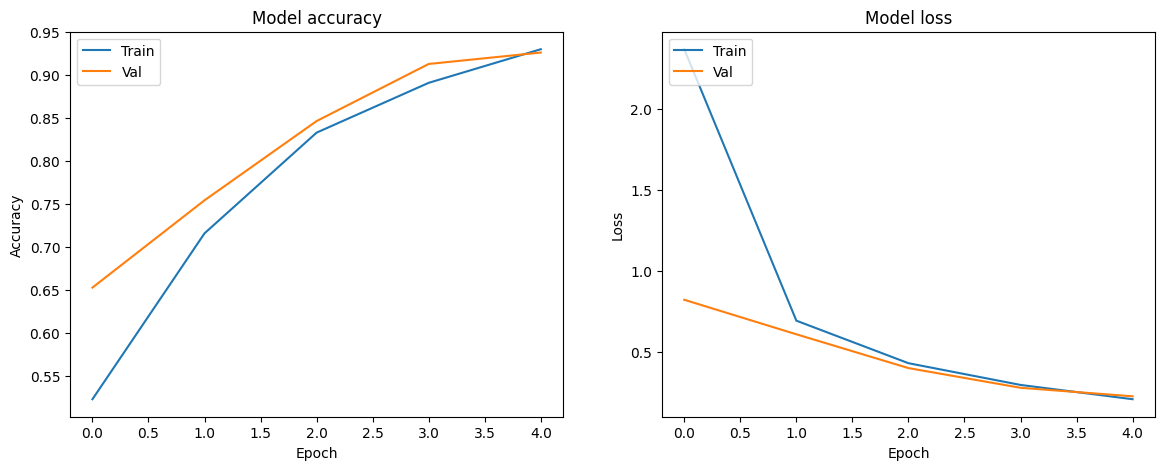

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

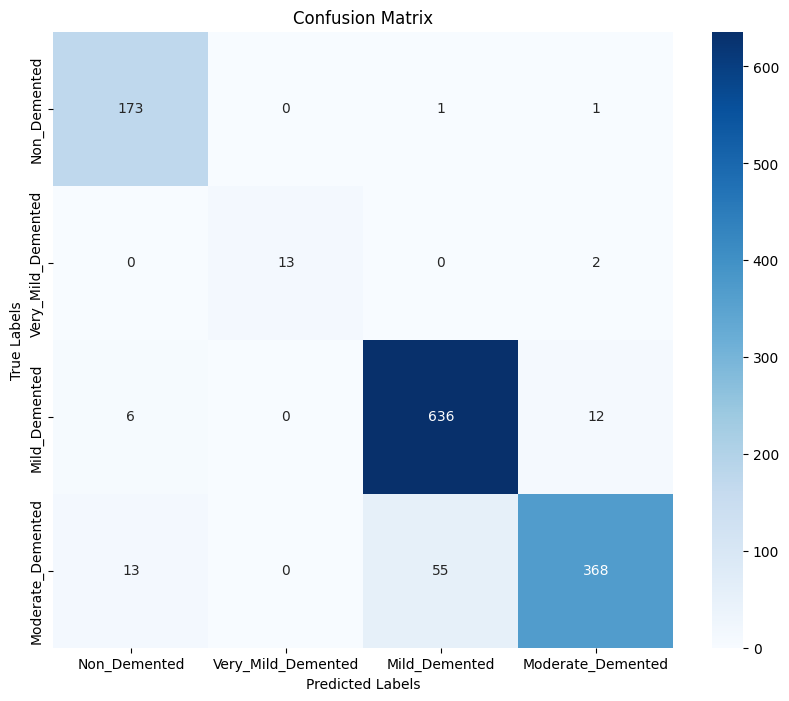

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

conf_matrix = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Transfer Learning Modeling

## Data Preprocessing

In [ ]:
# Assuming X_train_augment is your grayscale image data with shape (7648, 128, 128)
# First, add a new axis to create a single channel dimension
X_train_augment = X_train_augment[..., np.newaxis]  # This will change the shape to (7648, 128, 128, 1)

# Now, repeat the single channel 3 times along the channel axis
X_train_augment_rgb = np.repeat(X_train_augment, 3, axis=-1)  # This will change the shape to (7648, 128, 128, 3)

print("Shape after conversion to RGB:", X_train_augment_rgb.shape)

X_val = X_val[..., np.newaxis]  # This will change the shape to (7648, 128, 128, 1)

# Now, repeat the single channel 3 times along the channel axis
X_val_rgb = np.repeat(X_val, 3, axis=-1)  # This will change the shape to (7648, 128, 128, 3)

print("Shape after conversion to RGB:", X_val_rgb.shape)

X_test = X_test[..., np.newaxis]  # This will change the shape to (7648, 128, 128, 1)

# Now, repeat the single channel 3 times along the channel axis
X_test_rgb = np.repeat(X_test, 3, axis=-1)  # This will change the shape to (7648, 128, 128, 3)

print("Shape after conversion to RGB:", X_test_rgb.shape)

Shape after conversion to RGB: (7648, 128, 128, 3)
Shape after conversion to RGB: (1280, 128, 128, 3)
Shape after conversion to RGB: (1280, 128, 128, 3)


In [ ]:
y_train_oh = to_categorical(y_train, num_classes=4)
y_val_oh = to_categorical(y_val, num_classes=4)
y_test_oh = to_categorical(y_test, num_classes=4)

## Transfer Learning Model #1 (EfficientNetB0)

In [ ]:
IMG_SIZE = (128,128)
IMG_SHAPE = IMG_SIZE + (3,) # Add a third dimension for RGB channel

base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMG_SHAPE,
    #pooling=max,
    classes=4,
    classifier_activation="softmax"
)
base_model.trainable = False


In [ ]:
inputs = keras.Input(shape=IMG_SHAPE) # Input layer

x = base_model(inputs) # EfficientNetB0
x = layers.GlobalAveragePooling2D()(x) # Pooling layer
x = layers.Dropout(0.1)(x) # Dropout layer

outputs = layers.Dense(4, activation= 'softmax')(x) # Classification layer

# Build the model
model = keras.Model(inputs, outputs)

In [ ]:
# Specify metrics, loss function, and optimizer
metrics =[keras.metrics.CategoricalAccuracy(), keras.metrics.FalsePositives(),
            keras.metrics.TruePositives(), keras.metrics.FalseNegatives(),
            keras.metrics.TrueNegatives()]
loss = keras.losses.CategoricalCrossentropy() #(from_logits=True)
optimizer = keras.optimizers.Adam

# Create learning rates for two phases of training
learning_rates = [1e-3, 1e-4]

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizer(learning_rates[0]),
    loss=loss,
    metrics=metrics,
)

# Train the model
phase_1_history = model.fit(
    x = X_train_augment,
    y = y_train_oh,
    epochs=1,
    validation_data=(X_val, y_val_oh)
)

239/239 [==============================] - 208s 824ms/step - loss: 0.7838 - categorical_accuracy: 0.6539 - false_positives_15: 1183.0000 - true_positives_15: 3866.0000 - false_negatives_15: 3782.0000 - true_negatives_15: 21761.0000 - val_loss: 0.8962 - val_categorical_accuracy: 0.5766 - val_false_positives_15: 248.0000 - val_true_positives_15: 546.0000 - val_false_negatives_15: 734.0000 - val_true_negatives_15: 3592.0000


In [ ]:
# Phase 2: Fine tuning
base_model.trainable = True

# We only update parameters from layer 221 onwards
fine_tune_at = 221
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
# Since we've changed the attribute of the base model
# we need to compile the model again to capture this change.
model.compile(
    optimizer=optimizer(learning_rates[1]),
    loss=loss,
    metrics=metrics
)

# Train the model
phase_2_history = model.fit(
    x = X_train_augment,
    y = y_train_oh,
    epochs=1,
    initial_epoch=phase_1_history.epoch[-1],
    validation_data = (X_val, y_val_oh)
)

239/239 [==============================] - 218s 850ms/step - loss: 0.7641 - categorical_accuracy: 0.6484 - false_positives_15: 1664.0000 - true_positives_15: 4709.0000 - false_negatives_15: 4219.0000 - true_negatives_15: 25120.0000 - val_loss: 0.7975 - val_categorical_accuracy: 0.6313 - val_false_positives_15: 270.0000 - val_true_positives_15: 653.0000 - val_false_negatives_15: 627.0000 - val_true_negatives_15: 3570.0000


In [ ]:
predicts = model.predict(X_test_rgb)

40/40 [==============================] - 42s 993ms/step


In [ ]:
loss, accuracy, *_ = model.evaluate(X_test_rgb, y_test_oh)

40/40 [==============================] - 32s 780ms/step - loss: 0.7855 - categorical_accuracy: 0.6469 - false_positives_15: 275.0000 - true_positives_15: 671.0000 - false_negatives_15: 609.0000 - true_negatives_15: 3565.0000


## Transfer Learning Model #2 (Baseline VGG16)

In [ ]:
# Load the base VGG16 model, pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the output of the base model
x = Flatten()(base_model.output)
x = Dense(1028, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # We have 4 classes for this example

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model before any training
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on new data (freezing the convolutional VGG16 model)
history = model.fit(
    X_train_augment_rgb, y_train_oh,
    epochs=10,  # The number of epochs to train for
    validation_data=(X_val_rgb, y_val_oh)
)

Epoch 1/10
239/239 [==============================] - 13s 50ms/step - loss: 2.2836 - accuracy: 0.6760 - val_loss: 1.4311 - val_accuracy: 0.6797
Epoch 2/10
239/239 [==============================] - 13s 55ms/step - loss: 0.7375 - accuracy: 0.8288 - val_loss: 1.6586 - val_accuracy: 0.6531
Epoch 3/10
239/239 [==============================] - 13s 56ms/step - loss: 0.4044 - accuracy: 0.8876 - val_loss: 0.9160 - val_accuracy: 0.7664
Epoch 4/10
239/239 [==============================] - 13s 54ms/step - loss: 0.1886 - accuracy: 0.9404 - val_loss: 0.8879 - val_accuracy: 0.7922
Epoch 5/10
239/239 [==============================] - 12s 49ms/step - loss: 0.2402 - accuracy: 0.9300 - val_loss: 1.3325 - val_accuracy: 0.7141
Epoch 6/10
239/239 [==============================] - 12s 49ms/step - loss: 0.1080 - accuracy: 0.9643 - val_loss: 0.7896 - val_accuracy: 0.8227
Epoch 7/10
239/239 [==============================] - 12s 49ms/step - loss: 0.0998 - accuracy: 0.9672 - val_loss: 0.8736 - val_accuracy:

In [ ]:
# After the initial training, you may want to set the later layers of the VGG16 model to be trainable for fine-tuning
for layer in base_model.layers[-8:]:  # This unfreezes the last 8 layers for fine-tuning
    layer.trainable = True

# Recompile the model for fine-tuning
# Use a lower learning rate to fine-tune the pre-trained layers
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model for fine-tuning
# Note: You may need to use a smaller number of epochs and adjust the learning rate
fine_tune_history = model.fit(
    X_train_augment_rgb, y_train_oh,
    epochs=5,  # The number of epochs to fine-tune for
    validation_data=(X_val_rgb, y_val_oh)
)

Epoch 1/5
239/239 [==============================] - 26s 85ms/step - loss: 0.1790 - accuracy: 0.9484 - val_loss: 0.7059 - val_accuracy: 0.8453
Epoch 2/5
239/239 [==============================] - 19s 80ms/step - loss: 0.0580 - accuracy: 0.9796 - val_loss: 0.6861 - val_accuracy: 0.8578
Epoch 3/5
239/239 [==============================] - 20s 83ms/step - loss: 0.0877 - accuracy: 0.9703 - val_loss: 0.5505 - val_accuracy: 0.8453
Epoch 4/5
239/239 [==============================] - 19s 78ms/step - loss: 0.0561 - accuracy: 0.9818 - val_loss: 0.3292 - val_accuracy: 0.9203
Epoch 5/5
239/239 [==============================] - 19s 80ms/step - loss: 0.0478 - accuracy: 0.9850 - val_loss: 0.6310 - val_accuracy: 0.8539


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test_oh)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 2s 42ms/step - loss: 0.6004 - accuracy: 0.8562
Test Loss: 0.6003860235214233
Test Accuracy: 0.856249988079071


In [ ]:
model_save_path = "/content/drive/My Drive/207_Project/Preprocessed_2D_Models/VGG16_basic.h5"

# Save the model in the TensorFlow SavedModel format
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Transfer Learning Model #3 (Finetuned Advanced VGG16)

In [ ]:
# Load the base VGG16 model, pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the output of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # We have 4 classes for this example

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model before any training
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on new data (freezing the convolutional VGG16 model)
history = model.fit(
    X_train_augment_rgb, y_train_oh,
    epochs=10,  # The number of epochs to train for
    validation_data=(X_val_rgb, y_val_oh)
)

Epoch 1/10
239/239 [==============================] - 15s 59ms/step - loss: 1.9450 - accuracy: 0.6570 - val_loss: 1.6078 - val_accuracy: 0.6094
Epoch 2/10
239/239 [==============================] - 12s 52ms/step - loss: 0.6743 - accuracy: 0.8107 - val_loss: 1.3523 - val_accuracy: 0.6539
Epoch 3/10
239/239 [==============================] - 12s 49ms/step - loss: 0.3481 - accuracy: 0.8847 - val_loss: 0.9195 - val_accuracy: 0.7234
Epoch 4/10
239/239 [==============================] - 12s 48ms/step - loss: 0.1925 - accuracy: 0.9293 - val_loss: 1.1223 - val_accuracy: 0.7289
Epoch 5/10
239/239 [==============================] - 12s 52ms/step - loss: 0.1926 - accuracy: 0.9367 - val_loss: 0.8969 - val_accuracy: 0.7586
Epoch 6/10
239/239 [==============================] - 12s 48ms/step - loss: 0.0843 - accuracy: 0.9691 - val_loss: 0.5142 - val_accuracy: 0.8406
Epoch 7/10
239/239 [==============================] - 12s 52ms/step - loss: 0.0529 - accuracy: 0.9814 - val_loss: 0.6016 - val_accuracy:

In [ ]:
# After the initial training, you may want to set the later layers of the VGG16 model to be trainable for fine-tuning
for layer in base_model.layers[-8:]:  # This unfreezes the last 8 layers for fine-tuning
    layer.trainable = True

# Recompile the model for fine-tuning
# Use a lower learning rate to fine-tune the pre-trained layers
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model for fine-tuning
# Note: You may need to use a smaller number of epochs and adjust the learning rate
fine_tune_history = model.fit(
    X_train_augment_rgb, y_train_oh,
    epochs=4,  # The number of epochs to fine-tune for
    validation_data=(X_val_rgb, y_val_oh)
)

Epoch 1/4
239/239 [==============================] - 24s 80ms/step - loss: 0.1061 - accuracy: 0.9663 - val_loss: 0.4246 - val_accuracy: 0.8891
Epoch 2/4
239/239 [==============================] - 19s 79ms/step - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.3763 - val_accuracy: 0.9055
Epoch 3/4
239/239 [==============================] - 20s 82ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.3453 - val_accuracy: 0.9141
Epoch 4/4
239/239 [==============================] - 19s 82ms/step - loss: 0.0213 - accuracy: 0.9940 - val_loss: 0.3574 - val_accuracy: 0.8977


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test_oh)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 2s 41ms/step - loss: 0.3221 - accuracy: 0.9086
Test Loss: 0.32207030057907104
Test Accuracy: 0.9085937738418579


In [ ]:
model_save_path = "/content/drive/My Drive/207_Project/Preprocessed_2D_Models/VGG16_advanced.h5"

# Save the model in the TensorFlow SavedModel format
model.save(model_save_path)

40/40 [==============================] - 2s 42ms/step
                    precision    recall  f1-score   support

      Non_Demented       0.88      0.91      0.90       175
Very_Mild_Demented       1.00      0.73      0.85        15
     Mild_Demented       0.93      0.92      0.92       654
 Moderate_Demented       0.89      0.90      0.89       436

          accuracy                           0.91      1280
         macro avg       0.92      0.87      0.89      1280
      weighted avg       0.91      0.91      0.91      1280



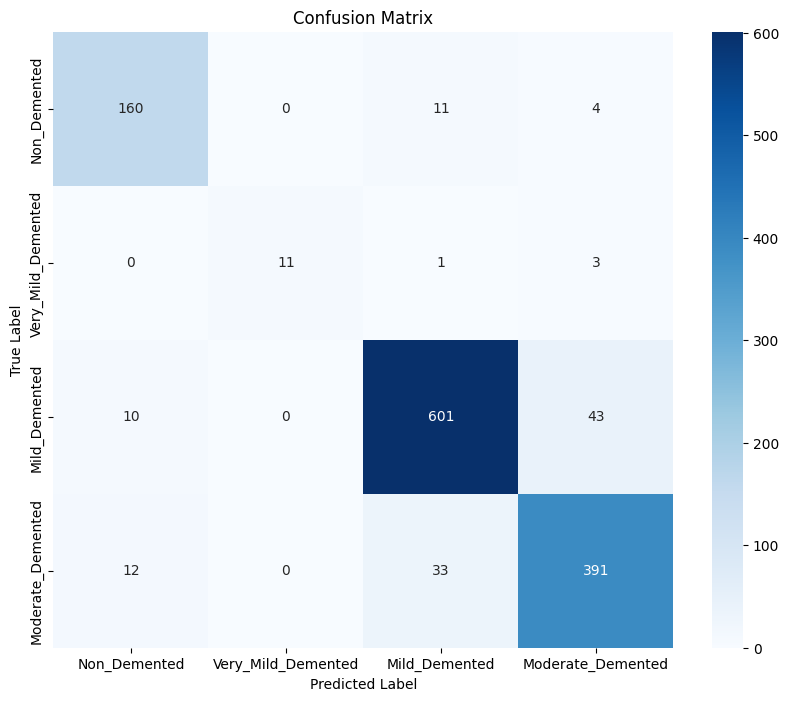

In [ ]:
# Generate predictions on the test set
y_pred_probs = model.predict(X_test_rgb)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_oh, axis=1)  # Assuming y_test_oh is the one-hot encoded true labels

# Generate a classification report
class_report = classification_report(y_true, y_pred, target_names=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'])
print(class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'], yticklabels=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Complex Finetuning but worse results

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the base VGG16 model, pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# New model with Batch Normalization
x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Increased dropout
predictions = layers.Dense(4, activation='softmax')(x)

# This is the model we will train
model = models.Model(inputs=base_model.input, outputs=predictions)

# Use a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_augment_rgb, y_train_oh, epochs=10, validation_data=(X_val_rgb, y_val_oh), callbacks=[reduce_lr])

Epoch 1/10
239/239 [==============================] - 23s 62ms/step - loss: 0.8026 - accuracy: 0.6642 - val_loss: 0.6483 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 2/10
239/239 [==============================] - 12s 49ms/step - loss: 0.4120 - accuracy: 0.8415 - val_loss: 0.5358 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 3/10
239/239 [==============================] - 12s 50ms/step - loss: 0.2946 - accuracy: 0.8915 - val_loss: 0.4894 - val_accuracy: 0.8344 - lr: 1.0000e-04
Epoch 4/10
239/239 [==============================] - 13s 53ms/step - loss: 0.2118 - accuracy: 0.9280 - val_loss: 0.4527 - val_accuracy: 0.8547 - lr: 1.0000e-04
Epoch 5/10
239/239 [==============================] - 11s 48ms/step - loss: 0.1649 - accuracy: 0.9523 - val_loss: 0.4384 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 6/10
239/239 [==============================] - 12s 51ms/step - loss: 0.1289 - accuracy: 0.9667 - val_loss: 0.4166 - val_accuracy: 0.8648 - lr: 1.0000e-04
Epoch 7/10
239/239 [==============

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for fine-tuning
fine_tune_history = model.fit(X_train_augment_rgb, y_train_oh, epochs=5, validation_data=(X_val_rgb, y_val_oh), callbacks=[reduce_lr])

Epoch 1/5
239/239 [==============================] - 23s 76ms/step - loss: 0.0772 - accuracy: 0.9796 - val_loss: 0.6413 - val_accuracy: 0.8234 - lr: 1.0000e-05
Epoch 2/5
239/239 [==============================] - 16s 65ms/step - loss: 0.0922 - accuracy: 0.9714 - val_loss: 0.5216 - val_accuracy: 0.8398 - lr: 1.0000e-05
Epoch 3/5
239/239 [==============================] - 16s 65ms/step - loss: 0.0958 - accuracy: 0.9738 - val_loss: 0.8288 - val_accuracy: 0.7602 - lr: 1.0000e-05
Epoch 4/5
239/239 [==============================] - 15s 63ms/step - loss: 0.0987 - accuracy: 0.9688 - val_loss: 0.4710 - val_accuracy: 0.8469 - lr: 1.0000e-05
Epoch 5/5
239/239 [==============================] - 14s 59ms/step - loss: 0.0998 - accuracy: 0.9695 - val_loss: 0.4624 - val_accuracy: 0.8484 - lr: 1.0000e-05


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test_oh)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 2s 41ms/step - loss: 0.4697 - accuracy: 0.8500
Test Loss: 0.4696931838989258
Test Accuracy: 0.8500000238418579


In [ ]:
model_save_path = "/content/drive/My Drive/207_Project/Preprocessed_2D_Models/VGG16_finetuned.h5"

# Save the model in the TensorFlow SavedModel format
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the model from Google Drive
# loaded_model = load_model(model_save_path)

40/40 [==============================] - 2s 41ms/step
                    precision    recall  f1-score   support

      Non_Demented       0.71      0.89      0.79       175
Very_Mild_Demented       0.72      0.87      0.79        15
     Mild_Demented       0.93      0.84      0.88       654
 Moderate_Demented       0.82      0.84      0.83       436

          accuracy                           0.85      1280
         macro avg       0.80      0.86      0.82      1280
      weighted avg       0.86      0.85      0.85      1280



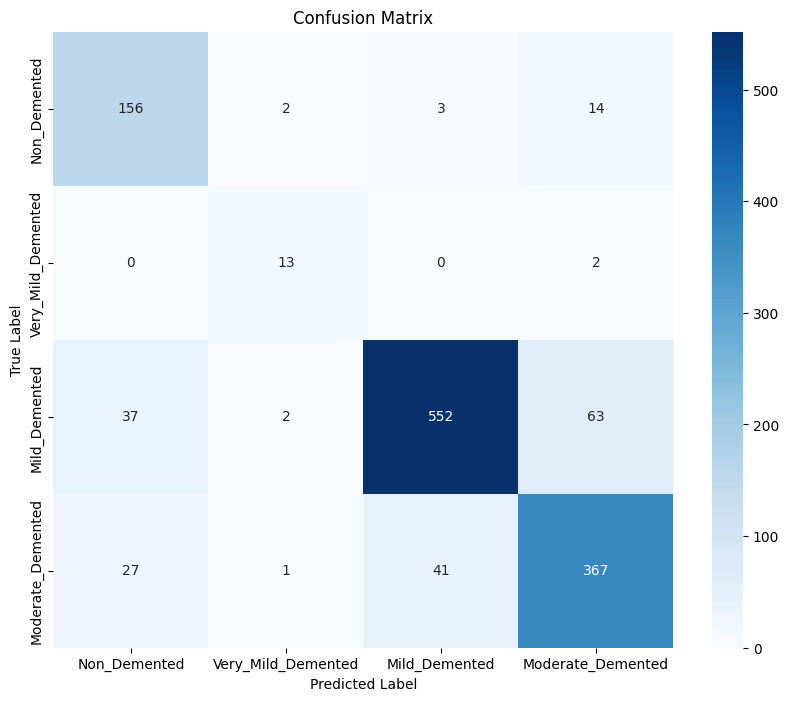

In [ ]:
# Generate predictions on the test set
y_pred_probs = model.predict(X_test_rgb)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_oh, axis=1)  # Assuming y_test_oh is the one-hot encoded true labels

# Generate a classification report
class_report = classification_report(y_true, y_pred, target_names=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'])
print(class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'], yticklabels=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()